<a href="https://colab.research.google.com/github/Asciotti/neural-sar/blob/master/notebooks/1_simple_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reimplementing simple autoencoder network to colorize images

Ref [Generating High Quality Visible Images from SAR Images Using CNNs](https://arxiv.org/abs/1802.10036) by Puyang Wang & Vishal M. Patel

## Data Sources

~3k [High Resolution Orthoimages](https://www.usgs.gov/centers/eros/science/usgs-eros-archive-aerial-photography-high-resolution-orthoimagery-hro?qt-science_center_objects=0#qt-science_center_objects) manually downloaded from https://earthexplorer.usgs.gov/ 

In [2]:
# I currently store my data on google drive, but it is stored in the repo under 
# https://github.com/Asciotti/neural-sar/tree/master/notebooks/data
# You can also manually upload the data each session
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


### Imports

In [0]:
import numpy as np
import keras
import matplotlib.pyplot as plt
from skimage.io import imread
from keras.layers import  Input,Conv2D,BatchNormalization,Activation,Subtract,Add
from keras.models import Model, load_model
from keras.callbacks import CSVLogger, ModelCheckpoint, LearningRateScheduler
from keras.optimizers import Adam

In [12]:
name = 1
im = imread('/content/drive/My Drive/Colab Notebooks/1_ft_ortho_images/'  + str(int(name)) + '.png', as_gray=True)
print(im.size)

262144


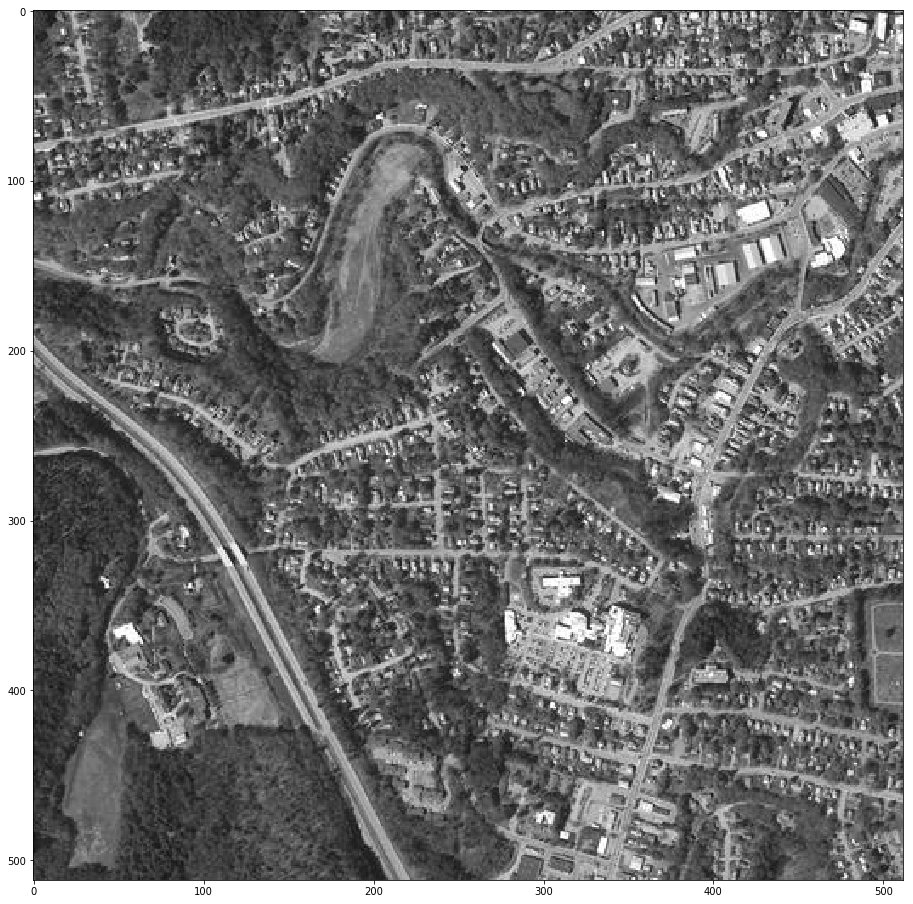

In [0]:
fig, axes = plt.subplots(1,1,figsize=(16,16))
axes.imshow(im, cmap='gray')